
# Fitting a Gaussian Process Operator (1D Heat Equation) with Linox



This walkthrough mirrors the 2D example, but for the 1D heat equation. We will:

1. generate synthetic 1D heat-equation data,
2. define a modular GP prior,
3. fit the operator, and
4. visualise predictions and uncertainty.



## Problem setup and analytic solution

We consider the 1D heat equation with homogeneous Dirichlet boundary conditions on a segment 
$(0, L)$ and initial condition $u_0(x)$:

$${\partial u \over \partial t}(x,t) = \alpha \; {\partial^2 u \over \partial x^2}(x,t), \qquad x \in (0,L),\; t \ge 0,\\
u(0,t)=u(L,t)=0, \qquad u(x,0)=u_0(x).$$

By separation of variables, the solution admits the sine-series expansion

$${u(x,t) = \sum_{n=1}^\infty b_n \exp\Big(-\alpha (n\pi/L)^2 t\Big) \sin(n\pi x/L)},$$

with Fourier coefficients

$${b_n = {2 \over L} \int_0^L u_0(x) \sin(n\pi x/L)\,dx.}$$

In this notebook, we set $L=\pi$ and evaluate the solution at a fixed time $t=T$. Initial 
conditions $u_0$ are drawn as finite random sine series. The dataset then consists of pairs 
$(u_0, u(\cdot, T))$.


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import linox as lo
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from helper.plotting import (
    generate_preprocess_data_1d,
    plot_kernel_predictions_1d,
    plot_kernel_predictions_1d_thesis,
)
from helper.gp import KernelType, CombinationStrategy
from helper.new_gp import (
    CombinationConfig,
    DimensionSpec,
    ModularGPPrior,
    StructureConfig,
    params_from_structure,
)

jax.config.update("jax_enable_x64", True)
plt.style.use("seaborn-v0_8")



## 1. Generate training and evaluation data

We draw random initial conditions, solve the 1D heat equation analytically, and
create train/test splits together with a dense grid used for plotting.


In [2]:
x_range = (0.0, np.pi)
nx = 20
nx_plot = 100
T = 10.0
alpha_value = 0.01
N_train = 40
N_test = 2

(
    operator_inputs,
    spatial_inputs,
    outputs,
    operator_inputs_test,
    spatial_inputs_test,
    outputs_test,
    spatial_inputs_plot,
) = generate_preprocess_data_1d(
    x_range=x_range,
    nx=nx,
    T=T,
    alpha=alpha_value,
    N_train=N_train,
    N_test=N_test,
    nx_plot=nx_plot,
)
spatial_inputs.shape, spatial_inputs_plot.shape

Generating 1D training data...
Solving 1D training data PDE...


((20, 1), (100, 1))


## 2. Configure the modular GP prior

We model the operator $\mathcal{G}: u_0 \mapsto u(\cdot, T)$ with a separable GP prior over 
pairs $((u,x))$ using the product kernel

$${k\big((u,x), (u',x')\big) = k_f(u,u')\; k_s(x,x'),}$$

where:
- $k_f(u,u') = \langle u, u' \rangle_{L^2} + b$ (L2 inner-product with bias $b>0$),
- $k_s(x,x') = \exp\!\big(-\tfrac{(x-x')^2}{2\ell^2}\big)$ (RBF kernel with lengthscale $\ell$).

With $N$ training functions sampled on a grid of size $M$, the training covariance takes 
Kronecker form $K_{\text{train}} = K_f \otimes K_s$. We add isotropic noise $\sigma^2 I$ 
for stability. Hyperparameters are kept in a structured dictionary to allow optimisation; 
here we use defaults for illustration.


In [3]:
structure_config = StructureConfig(
    spatial_dims=[
        DimensionSpec(name="x", kernel_type=KernelType.RBF),
    ],
    function_dims=[DimensionSpec(name="u", kernel_type=KernelType.L2)],
)

combination_config = CombinationConfig(
    strategy=CombinationStrategy.ADDITIVE,
    noise_variance=1e-6,
    output_scale=1.0,
)

prior = ModularGPPrior(structure_config, combination_config)
params = params_from_structure(structure_config)
params["spatial_x"]["lengthscale"] = jnp.log(2 * jnp.pi / 50)
params["output_scale"] = 1e-8
params["noise_variance"] = 1e-2
params


{'spatial_x': {'lengthscale': Array(-2.07414594, dtype=float64, weak_type=True)},
 'function_u': {'bias': Array(-1., dtype=float64, weak_type=True)},
 'output_scale': 1e-08,
 'noise_variance': 0.01}


## 3. Fit the operator and predict on new inputs

We build the training kernel, solve for the GP weights, and evaluate predictions and
uncertainty on a denser grid. Denote vectorised outputs by $y \in \mathbb{R}^{NM}$. 
Let $K = K_{\text{train}} + \sigma^2 I$, $K_* = k((u',x'), (u,x))$ and $K_{**} = k((u',x'),(u'',x''))$. 
The posterior is

$${m_* = K_* K^{-1} y, \qquad \; \; C_* = K_{**} - K_* K^{-1} K_*^\top.}$$


In [4]:
# Flatten the training outputs once for convenience
outputs_flat = outputs.reshape(-1, 1)

pred_mean_flat, pred_cov = prior.predict(
    operator_inputs,
    outputs,
    spatial_inputs,
    operator_inputs_test,
    spatial_inputs_plot,
    params,
)

# Reshape for plotting helpers
pred_mean_flat = pred_mean_flat.reshape(N_test, nx_plot)
pred_cov = pred_cov.todense().reshape(N_test, nx_plot, N_test, nx_plot)


## 4. Visualise predictions and uncertainty

/Users/lenardrommel/repos/linox/helper/plotting.py:393: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


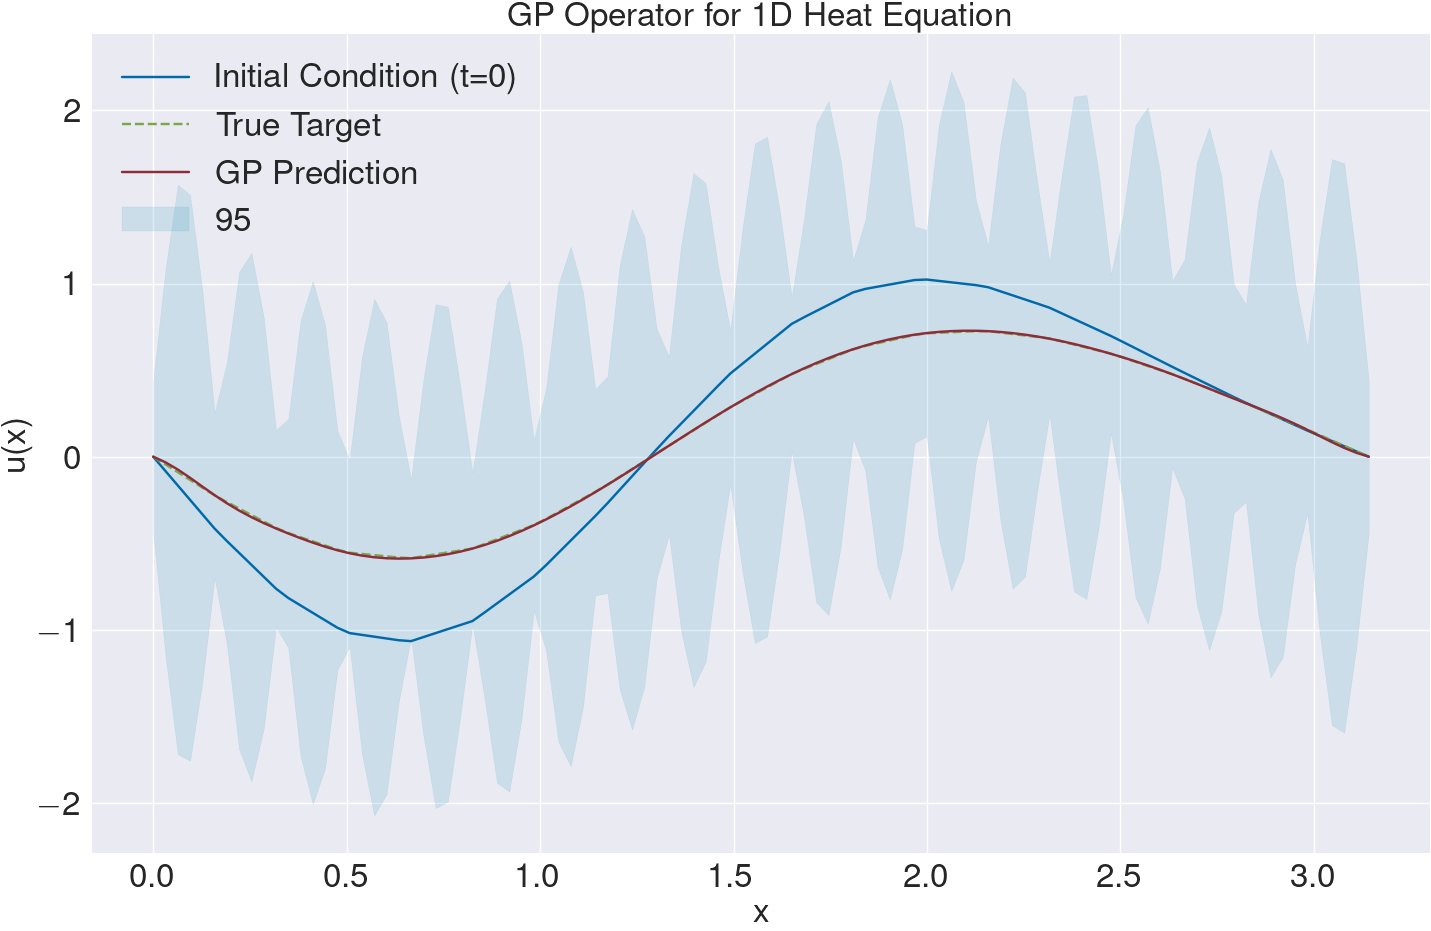

In [12]:
from tueplots import bundles

bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
{  # noqa: B018
    "text.usetex": False,
    "font.serif": ["Times"],
    "mathtext.fontset": "stix",
    "mathtext.rm": "Times",
    "mathtext.it": "Times:italic",
    "mathtext.bf": "Times:bold",
    "font.family": "sans-serif",
    "figure.figsize": (6.75, 8.343458848123582),
    "figure.constrained_layout.use": True,
    "figure.autolayout": False,
    "savefig.pad_inches": 0.015,
    "font.size": 48,
    "axes.labelsize": 24,
    "legend.fontsize": 24,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "axes.titlesize": 24,
}
from tueplots import axes
from helper.plotting import apply_tueplots_rc

axes.lines()
{'axes.linewidth': 0.5, 'lines.linewidth': 1.0, 'xtick.major.width': 0.5, 'ytick.major.width': 0.5, 'xtick.minor.width': 0.25, 'ytick.minor.width': 0.25, 'xtick.major.size': 3.0, 'ytick.major.size': 3.0, 'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0, 'grid.linewidth': 0.5, 'patch.linewidth': 0.5, 'legend.edgecolor': 'inherit', 'axes.axisbelow': True}

axes.lines(base_width=0.5)
plot_kernel_predictions_1d_thesis(
            pred_mean_flat,
            pred_cov,
            outputs_test,
            operator_inputs_test,
            spatial_inputs_plot,
            spatial_inputs_test,
            nx,
            nx_plot,
            N_test,
            title="GP Operator for 1D Heat Equation",
        )

apply_tueplots_rc(column="full", usetex=True, axes_labelsize=24, legend_fontsize=24, tick_labelsize=24, title_size=24)
plt.show()